# Tasks
1. Please train and test a model that predicts the likelihood that an account will spend in the next fiscal quarter. 

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import functools as ft
import json
import re
import os
import collections
import pandas as pd
from pandas.io.json import json_normalize
from scipy.signal import butter, filtfilt, lfilter
import random
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud,STOPWORDS
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import mean_squared_error,f1_score,accuracy_score,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import NearMiss

### Functions

In [2]:
def column_distribution(df, field_name="Outcome"):

    existing_fields = df.columns

    if type(field_name) != list and field_name in existing_fields:
        dist = df[field_name].value_counts(dropna=False).reset_index(name="Count")
        field_name = [field_name]
    else:
        field_name = [field for field in field_name if field in existing_fields]
        dist = df[field_name].fillna("NaN").value_counts().reset_index(name="Count")
    dist["Freq %"] = round(dist["Count"] / (dist["Count"].sum()) * 100, 3).map(
        "{:,.2f}%".format
    )
    dist["Count"] = dist["Count"].map("{:,.0f}".format)
    dist.columns = field_name + ["Count", "Freq %"]
    return dist

def get_firing_rates(df):
    def highlight_null(v, props=""):
        return np.where(v.values != "0.00%", props, "")

    for col in df:
        df[col] = np.where(pd.isnull(df[col]), df[col], df[col].astype(str))

    fire_rates = df.describe().T
    fire_rates["Unique %"] = (fire_rates["unique"] / df.shape[0] * 100).map(
        "{:,.2f}%".format
    )
    fire_rates["Fire Rate %"] = (fire_rates["count"] / df.shape[0] * 100).map(
        "{:,.2f}%".format
    )
    fire_rates["Null Rate %"] = ((1 - (fire_rates["count"] / df.shape[0])) * 100).map(
        "{:,.2f}%".format
    )
    fire_rates["count"] = fire_rates["count"].map("{:,.0f}".format)
    fire_rates["unique"] = fire_rates["unique"].map("{:,.0f}".format)
    fire_rates["freq"] = fire_rates["freq"].map("{:,.0f}".format)
    fire_rates = fire_rates.rename(
        columns={
            "count": "Count",
            "unique": "Unique",
            "top": "Most Common Value",
            "freq": "Freq",
            "unique %": "Unique %",
        }
    )
    fire_rates_styled = fire_rates.style.apply(
        highlight_null,
        props="color:red; background-color:#ffffb3",
        subset=["Null Rate %"],
        axis=0,
    )
    display(fire_rates_styled)
    
def plot_distribution_comparison(
    score1,
    score2,
    label1="score1",
    label2="score2",
    bins=20,
    stat="percent",
    title='title',
    print_kl=True,
    show_top_decile=False,
):

    def percents(x, pos):
        return "%.2f%%" % (x)

    ax = sns.histplot(score1, stat=stat, bins=bins, alpha=0.6, label=label1)
    sns.histplot(score2, stat=stat, bins=bins, alpha=0.6, color="r", label=label2)
    if print_kl:
        plt.title(
            "Score Distribution, KL= {0:.4f}".format(
                kl_divergence(score1, score2)
            )
        )
    else:
        plt.title(title)
    plt.xlabel("Score")
    h,l = ax.get_legend_handles_labels()
    ax.legend(h[1:3],l[1:3],prop={"size": 10})
    if stat == "percent":
        formatter = FuncFormatter(percents)
        ax.yaxis.set_major_formatter(formatter)
    if show_top_decile:
        plt.xlim([0.9, 1])
        
        
        
from matplotlib.ticker import FuncFormatter
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))


## Read Data

In [5]:
df_bookings=pd.read_csv('bookings.gzip',compression='gzip')
df_eval=pd.read_csv('eval.gzip',compression='gzip')

In [6]:
get_firing_rates(df_bookings)# Check firing rates of each column

,Count,Unique,Most Common Value,Freq,Unique %,Fire Rate %,Null Rate %
CUSTOMER_ID,"104,440","52,306",10586773097569850182,34,50.08%,100.00%,0.00%
NEXT_QUARTER_BOOKINGS,"104,440","12,590",0.0,"66,124",12.05%,100.00%,0.00%
REGION,"102,808",3,Eastern U.S.,"64,110",0.00%,98.44%,1.56%
COMPANY_SIZE,"104,440",6,1 to 99,"49,958",0.01%,100.00%,0.00%
SEGMENT,"104,440",6,SMALL,"53,617",0.01%,100.00%,0.00%
INITIAL_BOOKED_QUARTER,"104,425",39,2016Q2,"21,303",0.04%,99.99%,0.01%
LIFETIME_BOOKINGS_BEFORE_PURCHASE,"65,785","30,705",389.72,482,29.40%,62.99%,37.01%
DEFERRED_PAYMENT_PROGRAM,"104,440",2,False,"90,595",0.00%,100.00%,0.00%
BOOKING_TYPE,"104,440",2,End Cust,"98,490",0.00%,100.00%,0.00%
BOOKED_FISCAL_QUARTER,"104,440",2,2016Q3,"55,003",0.00%,100.00%,0.00%


In [7]:
get_firing_rates(df_eval)

,Count,Unique,Most Common Value,Freq,Unique %,Fire Rate %,Null Rate %
CUSTOMER_ID,"54,172","31,954",17780814737591576583,16,58.99%,100.00%,0.00%
REGION,"53,370",3,Eastern U.S.,"33,815",0.01%,98.52%,1.48%
COMPANY_SIZE,"54,172",6,1 to 99,"26,721",0.01%,100.00%,0.00%
SEGMENT,"54,172",6,SMALL,"28,795",0.01%,100.00%,0.00%
INITIAL_BOOKED_QUARTER,"54,160",43,2017Q1,"18,870",0.08%,99.98%,0.02%
LIFETIME_BOOKINGS_BEFORE_PURCHASE,"35,253","17,801",389.72,173,32.86%,65.08%,34.92%
DEFERRED_PAYMENT_PROGRAM,"54,172",2,False,"46,993",0.00%,100.00%,0.00%
BOOKING_TYPE,"54,172",2,End Cust,"51,206",0.00%,100.00%,0.00%
BOOKED_FISCAL_QUARTER,"54,172",1,2017Q1,"54,172",0.00%,100.00%,0.00%
PRODUCT_CAT,"54,172",3,Y,"23,450",0.01%,100.00%,0.00%


### Aggregate Quantity and Total price on the line level
1-  For each customer_id and each booked_fiscal_quarter, I calcauletd the sum of quantity and the total price  

2- For each customer_id and each booked_fiscal_quarter, I calcauletd the count of  unique product_cat and sku

In [8]:
df_bookings=pd.read_csv('bookings.gzip',compression='gzip')
df_eval=pd.read_csv('eval.gzip',compression='gzip')

df1=df_bookings.groupby(['CUSTOMER_ID','BOOKED_FISCAL_QUARTER']).sum()[['QUANTITY','TOTALPRICE']]
df1.reset_index(inplace=True)
df2=df_bookings.groupby(['CUSTOMER_ID','BOOKED_FISCAL_QUARTER'])[['PRODUCT_CAT','SKU']].nunique()
df2.reset_index(inplace=True)
#joine df1 and df2 to have aggregations on the line level in one dataframe
df_line_level=pd.merge(df1,df2, on=['CUSTOMER_ID','BOOKED_FISCAL_QUARTER'], how='left')
df_line_level.head()

,CUSTOMER_ID,BOOKED_FISCAL_QUARTER,QUANTITY,TOTALPRICE,PRODUCT_CAT,SKU
0,187425274304638,2016Q2,2.0,10610.12,1,1
1,211309033005671,2016Q2,3.0,1079.09,2,2
2,1065833176836294,2016Q3,1.0,389.72,1,1
3,1454679032233284,2016Q3,3.0,1010.25,2,2
4,1602831038006379,2016Q2,1.0,554.94,1,1


In [9]:
df_line_level.shape

(60800, 6)

#### Rename agg columns

In [10]:
df_line_level.columns=['CUSTOMER_ID','BOOKED_FISCAL_QUARTER','sum_QUANTITY','sum_TOTALPRICE','unique_count_PRODUCT_CAT','unique_count_SKU']

#### Each customer_id has unique region, company_size, segment, and defered payment program
- I keep only one row of each customer_id to keep account level information

In [11]:
df_account_level=df_bookings[['CUSTOMER_ID', 'NEXT_QUARTER_BOOKINGS', 'REGION', 'COMPANY_SIZE',
       'SEGMENT','BOOKED_FISCAL_QUARTER','DEFERRED_PAYMENT_PROGRAM']]
df_account_level=df_account_level.drop_duplicates()
df_account_level.shape

(60800, 7)

#### Join account level and line level dataframes

In [12]:
df=pd.merge(df_account_level,df_line_level,on=['CUSTOMER_ID','BOOKED_FISCAL_QUARTER'],how='inner')
df.head()

,CUSTOMER_ID,NEXT_QUARTER_BOOKINGS,REGION,COMPANY_SIZE,SEGMENT,BOOKED_FISCAL_QUARTER,DEFERRED_PAYMENT_PROGRAM,sum_QUANTITY,sum_TOTALPRICE,unique_count_PRODUCT_CAT,unique_count_SKU
0,187425274304638,0.0,Eastern U.S.,100 to 999,SMALL,2016Q2,False,2.0,10610.12,1,1
1,211309033005671,0.0,Canada,1 to 99,SMALL,2016Q2,False,3.0,1079.09,2,2
2,1065833176836294,0.0,Western U.S.,1 to 99,SMALL,2016Q3,False,1.0,389.72,1,1
3,1454679032233284,0.0,Eastern U.S.,1 to 99,SMALL,2016Q3,False,3.0,1010.25,2,2
4,1602831038006379,0.0,Canada,1 to 99,SMALL,2016Q2,False,1.0,554.94,1,1


## EDA and Preprocess the data 

- Lest check booking spread for each quarter

BOOKED_FISCAL_QUARTER
2016Q2    AxesSubplot(0.125,0.11;0.775x0.77)
2016Q3    AxesSubplot(0.125,0.11;0.775x0.77)
Name: NEXT_QUARTER_BOOKINGS, dtype: object

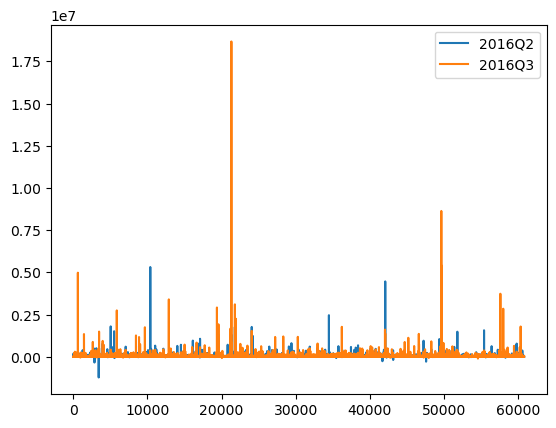

In [13]:
df.NEXT_QUARTER_BOOKINGS=df.NEXT_QUARTER_BOOKINGS.astype(float)
df.groupby('BOOKED_FISCAL_QUARTER')['NEXT_QUARTER_BOOKINGS'].plot(legend=True)

#### For running the classification to estimate the likelihood that an account will spend in the next fiscal quarter, I label all values equal or smaller than 0 as target=0 and positive values as 1


In [14]:
df.loc[df['NEXT_QUARTER_BOOKINGS']>0,'target']=1
df.loc[df['NEXT_QUARTER_BOOKINGS']<=0,'target']=0

### Lets check distribution of the target for each quarter
- Both quarters have almost similar rate (27.88~28.55%)

In [15]:
column_distribution(df[df.BOOKED_FISCAL_QUARTER=='2016Q3'],'target')

,target,Count,Freq %
0,0.0,"22,697",71.45%
1,1.0,"9,070",28.55%


In [16]:
column_distribution(df[df.BOOKED_FISCAL_QUARTER=='2016Q2'],'target')

,target,Count,Freq %
0,0.0,"20,938",72.12%
1,1.0,"8,095",27.88%


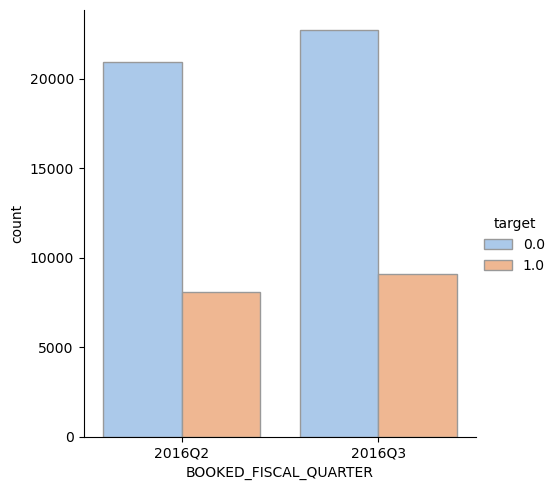

In [17]:
sns.catplot(
    data=df, x='BOOKED_FISCAL_QUARTER', hue='target', kind="count",
    palette="pastel", edgecolor=".6",
)

### Lets check the breakdown of other columns and preprocess data for the ML model

In [18]:
column_distribution(df, 'REGION')

,REGION,Count,Freq %
0,Eastern U.S.,"38,003",62.51%
1,Western U.S.,"15,179",24.96%
2,Canada,"6,647",10.93%
3,NaN,971,1.60%


In [19]:
df.loc[df.REGION=='Eastern U.S.','region']=1
df.loc[df.REGION=='Western U.S.','region']=2
df.loc[df.REGION=='Canada','region']=3
df.loc[df.REGION.isnull(),'region']=4

In [20]:
column_distribution(df, 'COMPANY_SIZE')

,COMPANY_SIZE,Count,Freq %
0,1 to 99,"32,133",52.85%
1,100 to 999,"17,368",28.57%
2,4000+,"5,042",8.29%
3,1000 to 1999,"3,508",5.77%
4,2000 to 3999,"1,553",2.55%
5,Unknown,"1,196",1.97%


In [21]:
df.loc[df.COMPANY_SIZE=='1 to 99','company_size']=1
df.loc[df.COMPANY_SIZE=='100 to 999','company_size']=2
df.loc[df.COMPANY_SIZE=='4000+','company_size']=3
df.loc[df.COMPANY_SIZE=='1000 to 1999','company_size']=4
df.loc[df.COMPANY_SIZE=='2000 to 3999','company_size']=5
df.loc[df.COMPANY_SIZE=='Unknown','company_size']=6

### Lets check the company_size vs Region breakdown

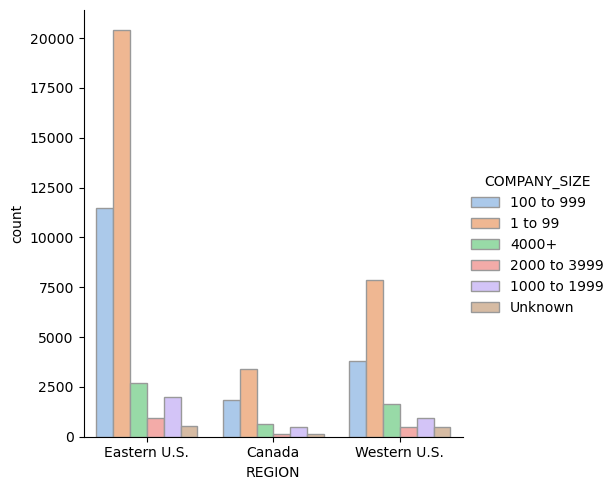

In [22]:
sns.catplot(
    data=df, x='REGION', hue='COMPANY_SIZE', kind="count",
    palette="pastel", edgecolor=".6",
)

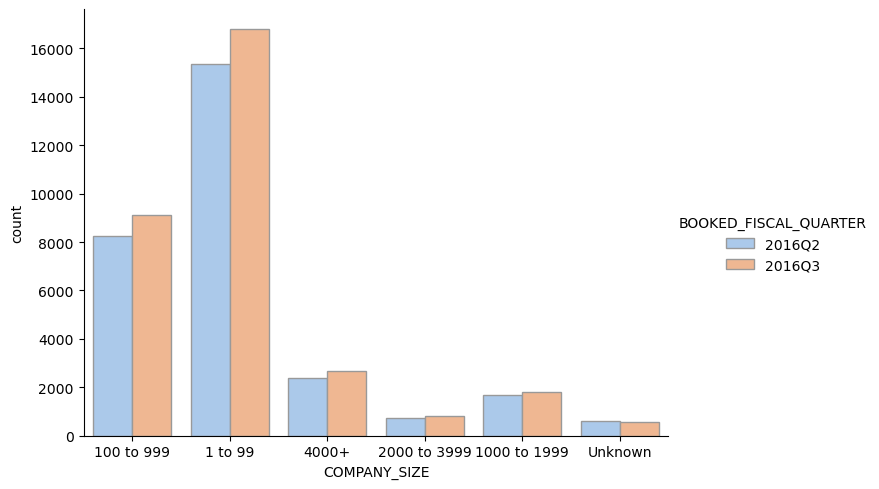

In [23]:
sns.catplot(
    data=df, x='COMPANY_SIZE', hue='BOOKED_FISCAL_QUARTER', kind="count",
    palette="pastel", edgecolor=".6", height=5, aspect=11.7/8.27)


In [24]:
column_distribution(df, 'SEGMENT')

,SEGMENT,Count,Freq %
0,SMALL,"34,805",57.24%
1,COMMERCIAL,"12,056",19.83%
2,OTHER,"6,026",9.91%
3,PUBLIC SECTOR,"5,248",8.63%
4,ENTERPRISE,"1,942",3.19%
5,SERVICE PROVIDER,723,1.19%


In [25]:
df.loc[df.SEGMENT=='SMALL','segment']=1
df.loc[df.SEGMENT=='COMMERCIAL','segment']=2
df.loc[df.SEGMENT=='OTHER','segment']=3
df.loc[df.SEGMENT=='PUBLIC SECTOR','segment']=4
df.loc[df.SEGMENT=='ENTERPRISE','segment']=5
df.loc[df.SEGMENT=='SERVICE PROVIDER','segment']=6

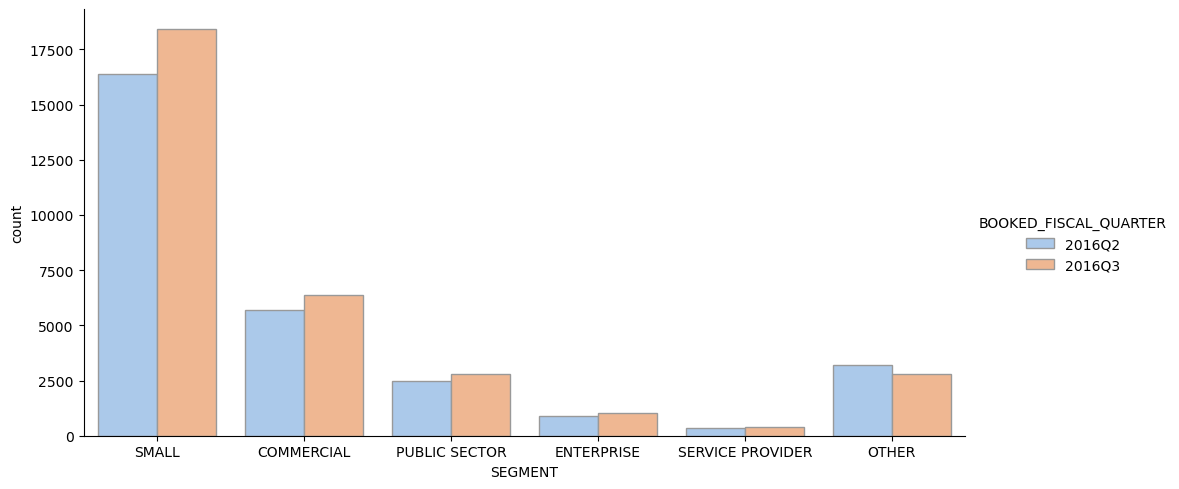

In [27]:
sns.catplot(
    data=df, x='SEGMENT', hue='BOOKED_FISCAL_QUARTER', kind="count",
    palette="pastel", edgecolor=".6", height=5, aspect=2)
plt.show()

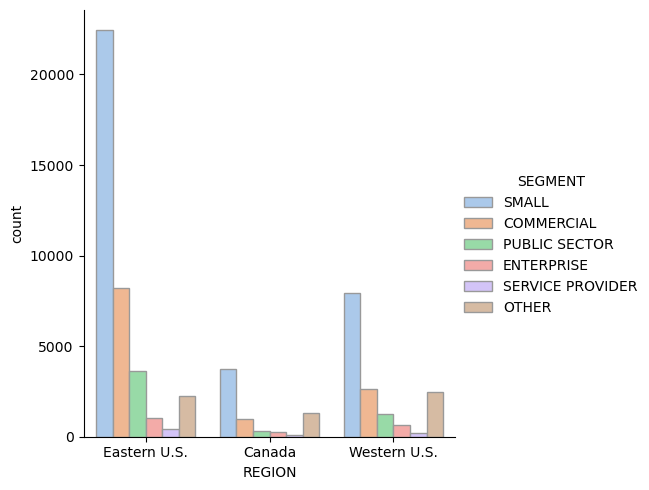

In [28]:
sns.catplot(
    data=df, x='REGION', hue='SEGMENT', kind="count",
    palette="pastel", edgecolor=".6",
)
plt.show()

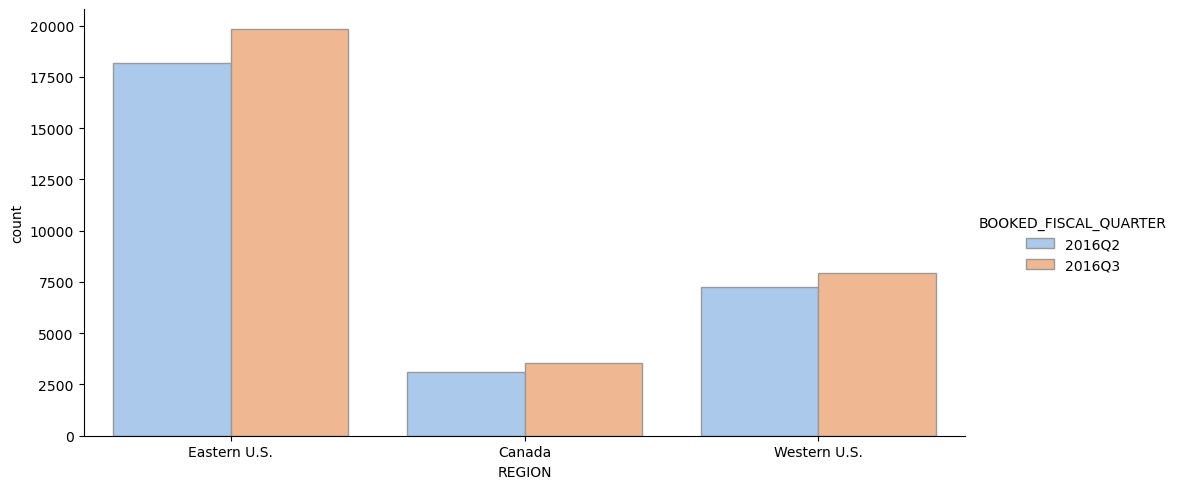

In [29]:
sns.catplot(
    data=df, x='REGION', hue='BOOKED_FISCAL_QUARTER', kind="count",
    palette="pastel", edgecolor=".6", height=5, aspect=2)
plt.show()

In [30]:
column_distribution(df,'DEFERRED_PAYMENT_PROGRAM')# no need to preprocess

,DEFERRED_PAYMENT_PROGRAM,Count,Freq %
0,False,"52,686",86.66%
1,True,"8,114",13.35%


In [31]:
column_distribution(df,'BOOKED_FISCAL_QUARTER')

,BOOKED_FISCAL_QUARTER,Count,Freq %
0,2016Q3,"31,767",52.25%
1,2016Q2,"29,033",47.75%


In [32]:
column_distribution(df,'unique_count_PRODUCT_CAT')

,unique_count_PRODUCT_CAT,Count,Freq %
0,1,"41,597",68.42%
1,2,"12,097",19.90%
2,3,"7,106",11.69%


In [33]:
column_distribution(df,'unique_count_SKU')

,unique_count_SKU,Count,Freq %
0,1,"38,176",62.79%
1,2,"12,309",20.25%
2,3,"6,629",10.90%
3,4,"2,263",3.72%
4,5,918,1.51%
5,6,339,0.56%
6,7,113,0.19%
7,8,43,0.07%
8,9,10,0.02%


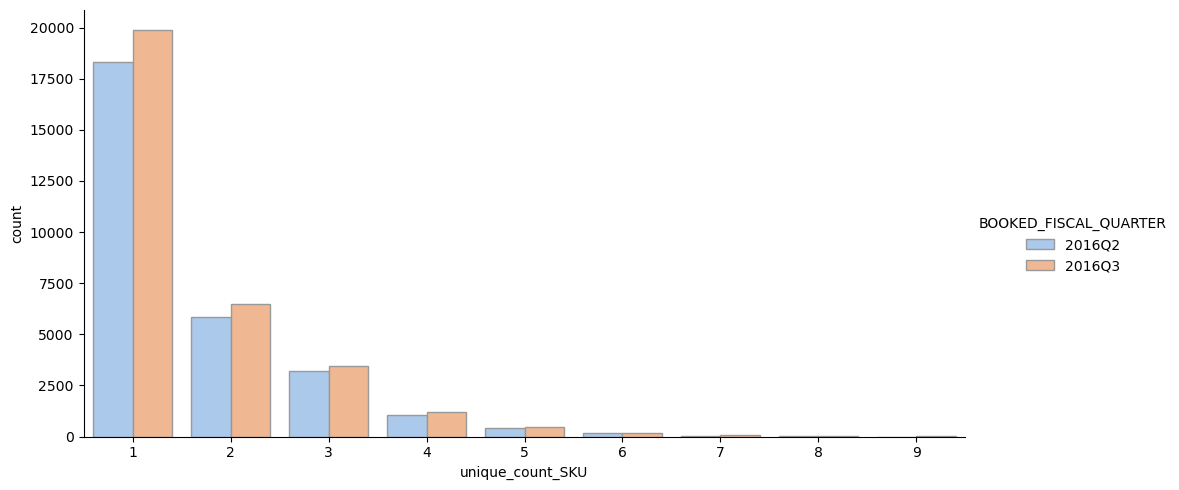

In [35]:
sns.catplot(
    data=df, x='unique_count_SKU', hue='BOOKED_FISCAL_QUARTER', kind="count",
    palette="pastel", edgecolor=".6", height=5, aspect=2)
plt.show()

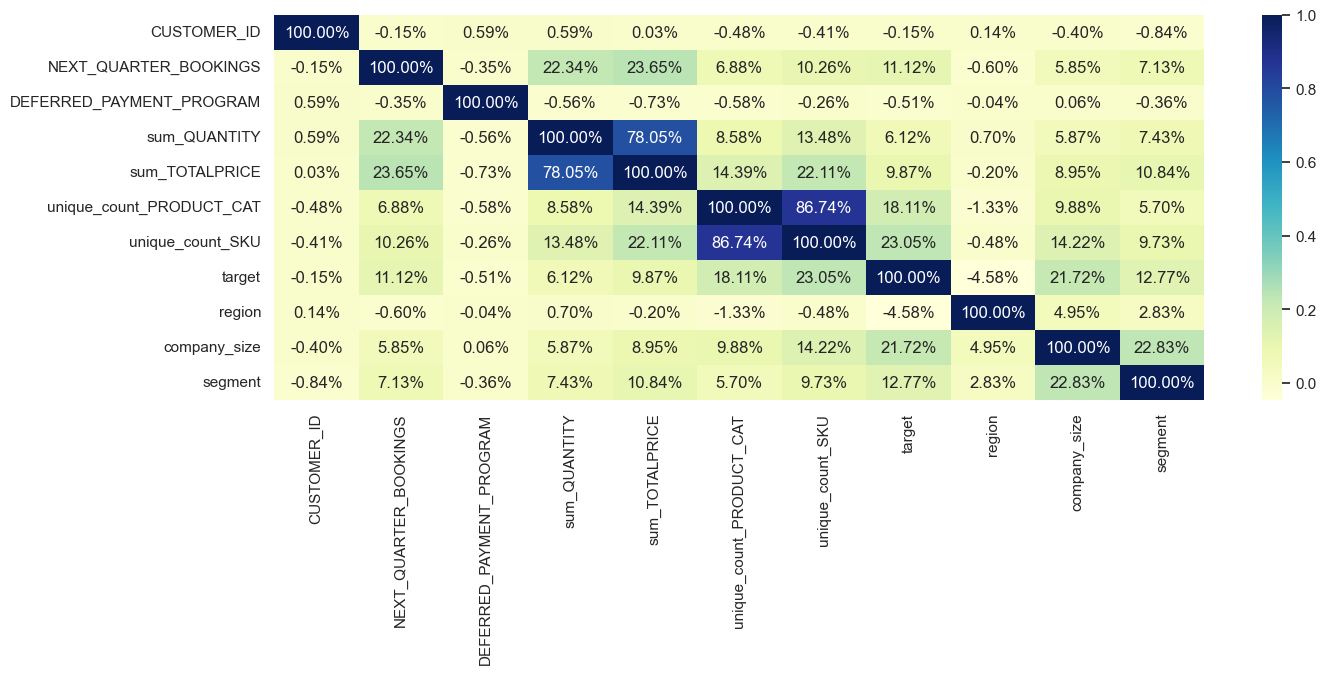

In [36]:
sns.set(rc={'figure.figsize':(15,5)})
dataplot = sns.heatmap(df.corr(),
                       cmap="YlGnBu", annot=True,fmt=".2%")
plt.show()


## 1- Pick input/output for the ML model (classification)
## 2- Split train/test data

In [37]:
#Inputs
X=df[['DEFERRED_PAYMENT_PROGRAM','sum_QUANTITY','sum_TOTALPRICE','unique_count_PRODUCT_CAT','unique_count_SKU',
      'region', 'company_size', 'segment','BOOKED_FISCAL_QUARTER']]
# Target
y=df[['target','BOOKED_FISCAL_QUARTER']]
# Keep 2016Q2 for the training
X_train=X[X.BOOKED_FISCAL_QUARTER=='2016Q2']
y_train=y[y.BOOKED_FISCAL_QUARTER=='2016Q2']
# Keep 2016Q3 for the test
X_test=X[X.BOOKED_FISCAL_QUARTER=='2016Q3']
y_test=y[y.BOOKED_FISCAL_QUARTER=='2016Q3']

# Drop fiscal quarter
X_train=X_train.drop('BOOKED_FISCAL_QUARTER',axis=1)
X_test=X_test.drop('BOOKED_FISCAL_QUARTER',axis=1)
y_train=y_train.drop('BOOKED_FISCAL_QUARTER',axis=1)
y_test=y_test.drop('BOOKED_FISCAL_QUARTER',axis=1)

# Normalization
# scaler = MinMaxScaler(feature_range = (0,1))
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [38]:
X_train.shape

(29033, 8)

In [39]:
X_test.shape

(31767, 8)

# Train Classifier

## Logistic Regression
- Start with linear classifier to check the preformance

In [40]:
lr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, 
                        class_weight=None, random_state=None, solver='lbfgs',
                        max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
lr.fit(X_train, y_train.values.ravel())
y_pred_train =lr.predict(X_train)
tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train).ravel()

accuracy=100*(tp+tn)/(tn+fp+fn+tp)
recall=100*(tp)/(fn+tp)
precision=100*(tp)/(tp+fp)
FPR=100*(fp)/(tn+fp)
FNR=100*(fn)/(fn+tp)
f1=2*(precision*recall)/(precision+recall)
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train, pos_label=1)


print('Logistic Regression Train Evaluations')
print('Accuracy_train:',"{:.2f}".format(accuracy),'%')
print('Recall_train:',"{:.2f}".format(recall),'%')
print('FPR_train:',"{:.2f}".format(FPR),'%')
print('FNR_train:',"{:.2f}".format(FNR),'%')
print('f1_train:',"{:.2f}".format(f1),'%')
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train, pos_label=1)
print('AUC train:',"{:.2f}".format(100*metrics.auc(fpr, tpr)),'%')



print('')
print("Logistic Regression Test Evaluations")
y_pred_test = lr.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test).ravel()
accuracy=100*(tp+tn)/(tn+fp+fn+tp)
recall=100*(tp)/(fn+tp)
precision=100*(tp)/(tp+fp)
FPR=100*(fp)/(tn+fp)
FNR=100*(fn)/(fn+tp)
f1=2*(precision*recall)/(precision+recall)

print('Accuracy_test:',"{:.2f}".format(accuracy),'%')
print('Recall_test:',"{:.2f}".format(recall),'%')
print('FPR_test:',"{:.2f}".format(FPR),'%')
print('FNR_test:',"{:.2f}".format(FNR),'%')
print('f1_test:',"{:.2f}".format(f1),'%')
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test, pos_label=1)
print('AUC test:',"{:.2f}".format(100*metrics.auc(fpr, tpr)),'%')

Logistic Regression Train Evaluations
Accuracy_train: 72.76 %
Recall_train: 14.70 %
FPR_train: 4.80 %
FNR_train: 85.30 %
f1_train: 23.13 %
AUC train: 54.95 %

Logistic Regression Test Evaluations
Accuracy_test: 72.45 %
Recall_test: 14.92 %
FPR_test: 4.56 %
FNR_test: 85.08 %
f1_test: 23.61 %
AUC test: 55.18 %


In [46]:
lr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=.1, fit_intercept=True, intercept_scaling=1, 
                        class_weight=None, random_state=None, solver='lbfgs',
                        max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)


lr.fit(X_train, y_train.values.ravel())
df_final=pd.DataFrame(lr.predict_proba(X_test), columns = ['prob_as_0','prob_as_1'])
predicted_probabilities=df_final['prob_as_1'].values
y_pred_train = lr.predict(X_train)
tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train).ravel()
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train, pos_label=1)
accuracy=100*(tp+tn)/(tn+fp+fn+tp)
recall=100*(tp)/(fn+tp)
precision=100*(tp)/(tp+fp)
FPR=100*(fp)/(tn+fp)
FNR=100*(fn)/(fn+tp)
f1=2*(precision*recall)/(precision+recall)



print('Logistic Regression Train Evaluations')
print('Accuracy_train:',"{:.2f}".format(accuracy),'%')
print('Recall_train:',"{:.2f}".format(recall),'%')
print('FPR_train:',"{:.2f}".format(FPR),'%')
print('FNR_train:',"{:.2f}".format(FNR),'%')
print('f1_train:',"{:.2f}".format(f1),'%')
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train, pos_label=1)
print('AUC train:',"{:.2f}".format(100*metrics.auc(fpr, tpr)),'%')




y_pred_test = lr.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test).ravel()
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test, pos_label=1)
accuracy=100*(tp+tn)/(tn+fp+fn+tp)
recall=100*(tp)/(fn+tp)
precision=100*(tp)/(tp+fp)
FPR=100*(fp)/(tn+fp)
FNR=100*(fn)/(fn+tp)
f1=2*(precision*recall)/(precision+recall)

print('')
print("Logistic Regression Test Evaluations")
print('Accuracy_test:',"{:.2f}".format(accuracy),'%')
print('Recall_test:',"{:.2f}".format(recall),'%')
print('FPR_test:',"{:.2f}".format(FPR),'%')
print('FNR_test:',"{:.2f}".format(FNR),'%')
print('f1_test:',"{:.2f}".format(f1),'%')
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test, pos_label=1)
print('AUC test:',"{:.2f}".format(100*metrics.auc(fpr, tpr)),'%')

Logistic Regression Train Evaluations
Accuracy_train: 72.76 %
Recall_train: 14.66 %
FPR_train: 4.79 %
FNR_train: 85.34 %
f1_train: 23.08 %
AUC train: 54.94 %

Logistic Regression Test Evaluations
Accuracy_test: 72.44 %
Recall_test: 14.85 %
FPR_test: 4.55 %
FNR_test: 85.15 %
f1_test: 23.53 %
AUC test: 55.15 %


### The Logistic Regression performance is fina and model is generalizing well since the perfromance for both train and test is almost equal, but lets check nonliear classifier's performance

## XGBoost Classifier

In [47]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=0 , eval_metric="auc")
xgb_model.fit(X_train, y_train.values.ravel())
y_pred_train = xgb_model.predict(X_train)
tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train).ravel()
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train, pos_label=1)
accuracy=100*(tp+tn)/(tn+fp+fn+tp)
recall=100*(tp)/(fn+tp)
precision=100*(tp)/(tp+fp)
FPR=100*(fp)/(tn+fp)
FNR=100*(fn)/(fn+tp)
f1=2*(precision*recall)/(precision+recall)



print('XGB Train Evaluations')
print('Accuracy_train:',"{:.2f}".format(accuracy),'%')
print('Recall_train:',"{:.2f}".format(recall),'%')
print('FPR_train:',"{:.2f}".format(FPR),'%')
print('FNR_train:',"{:.2f}".format(FNR),'%')
print('f1_train:',"{:.2f}".format(f1),'%')
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train, pos_label=1)
print('AUC train:',"{:.2f}".format(100*metrics.auc(fpr, tpr)),'%')




y_pred_test = xgb_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test).ravel()
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test, pos_label=1)
accuracy=100*(tp+tn)/(tn+fp+fn+tp)
recall=100*(tp)/(fn+tp)
precision=100*(tp)/(tp+fp)
FPR=100*(fp)/(tn+fp)
FNR=100*(fn)/(fn+tp)
f1=2*(precision*recall)/(precision+recall)

print('')
print("XGB Test Evaluations")
print('Accuracy_test:',"{:.2f}".format(accuracy),'%')
print('Recall_test:',"{:.2f}".format(recall),'%')
print('FPR_test:',"{:.2f}".format(FPR),'%')
print('FNR_test:',"{:.2f}".format(FNR),'%')
print('f1_test:',"{:.2f}".format(f1),'%')
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test, pos_label=1)
print('AUC test:',"{:.2f}".format(100*metrics.auc(fpr, tpr)),'%')

XGB Train Evaluations
Accuracy_train: 79.76 %
Recall_train: 40.38 %
FPR_train: 5.01 %
FNR_train: 59.62 %
f1_train: 52.67 %
AUC train: 67.68 %

XGB Test Evaluations
Accuracy_test: 75.09 %
Recall_test: 32.47 %
FPR_test: 7.88 %
FNR_test: 67.53 %
f1_test: 42.67 %
AUC test: 62.30 %


### The performance is better than Logisitic regression, lets check some other parameters to tune the model

### Hypertune Xgboost

In [48]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(objective= 'binary:logistic'),
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4)
gsearch1.fit(X_train, y_train.values.ravel())
gsearch1.best_params_

{'max_depth': 3, 'min_child_weight': 5}

In [49]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=0 , 
                              eval_metric="auc",max_depth= 3, min_child_weight=5)
xgb_model.fit(X_train, y_train.values.ravel())
y_pred_train = xgb_model.predict(X_train)
tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train).ravel()
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train, pos_label=1)
accuracy=100*(tp+tn)/(tn+fp+fn+tp)
recall=100*(tp)/(fn+tp)
precision=100*(tp)/(tp+fp)
FPR=100*(fp)/(tn+fp)
FNR=100*(fn)/(fn+tp)
f1=2*(precision*recall)/(precision+recall)



print('XGB Train Evaluations')
print('Accuracy_train:',"{:.2f}".format(accuracy),'%')
print('Recall_train:',"{:.2f}".format(recall),'%')
print('FPR_train:',"{:.2f}".format(FPR),'%')
print('FNR_train:',"{:.2f}".format(FNR),'%')
print('f1_train:',"{:.2f}".format(f1),'%')
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train, pos_label=1)
print('AUC train:',"{:.2f}".format(100*metrics.auc(fpr, tpr)),'%')

#########################################################

y_pred_test = xgb_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test).ravel()
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test, pos_label=1)
accuracy=100*(tp+tn)/(tn+fp+fn+tp)
recall=100*(tp)/(fn+tp)
precision=100*(tp)/(tp+fp)
FPR=100*(fp)/(tn+fp)
FNR=100*(fn)/(fn+tp)
f1=2*(precision*recall)/(precision+recall)

print('')
print("XGB Test Evaluations")
print('Accuracy_test:',"{:.2f}".format(accuracy),'%')
print('Recall_test:',"{:.2f}".format(recall),'%')
print('FPR_test:',"{:.2f}".format(FPR),'%')
print('FNR_test:',"{:.2f}".format(FNR),'%')
print('f1_test:',"{:.2f}".format(f1),'%')
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test, pos_label=1)
print('AUC test:',"{:.2f}".format(100*metrics.auc(fpr, tpr)),'%')

XGB Train Evaluations
Accuracy_train: 76.70 %
Recall_train: 33.07 %
FPR_train: 6.43 %
FNR_train: 66.93 %
f1_train: 44.18 %
AUC train: 63.32 %

XGB Test Evaluations
Accuracy_test: 75.47 %
Recall_test: 31.57 %
FPR_test: 6.99 %
FNR_test: 68.43 %
f1_test: 42.35 %
AUC test: 62.29 %


### The hypertuned model's performance is not that different from pervious model. Now lets check Random Forest model

# Random Forest

In [50]:
rf = RandomForestClassifier(n_estimators = 80,max_depth=14, random_state=0)  
rf.fit(X_train, y_train.values.ravel())
y_pred_train = rf.predict(X_train)

tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train).ravel()
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train, pos_label=1)
accuracy=100*(tp+tn)/(tn+fp+fn+tp)
recall=100*(tp)/(fn+tp)
precision=100*(tp)/(tp+fp)
FPR=100*(fp)/(tn+fp)
FNR=100*(fn)/(fn+tp)
f1=2*(precision*recall)/(precision+recall)



print('Random Forest Train Evaluations')
print('Accuracy_train:',"{:.2f}".format(accuracy),'%')
print('Recall_train:',"{:.2f}".format(recall),'%')
print('FPR_train:',"{:.2f}".format(FPR),'%')
print('FNR_train:',"{:.2f}".format(FNR),'%')
print('f1_train:',"{:.2f}".format(f1),'%')
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train, pos_label=1)
print('AUC train:',"{:.2f}".format(100*metrics.auc(fpr, tpr)),'%')

#########################################################

y_pred_test = xgb_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test).ravel()
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test, pos_label=1)
accuracy=100*(tp+tn)/(tn+fp+fn+tp)
recall=100*(tp)/(fn+tp)
precision=100*(tp)/(tp+fp)
FPR=100*(fp)/(tn+fp)
FNR=100*(fn)/(fn+tp)
f1=2*(precision*recall)/(precision+recall)

print('')
print("Random Forest Test Evaluations")
print('Accuracy_test:',"{:.2f}".format(accuracy),'%')
print('Recall_test:',"{:.2f}".format(recall),'%')
print('FPR_test:',"{:.2f}".format(FPR),'%')
print('FNR_test:',"{:.2f}".format(FNR),'%')
print('f1_test:',"{:.2f}".format(f1),'%')
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test, pos_label=1)
print('AUC test:',"{:.2f}".format(100*metrics.auc(fpr, tpr)),'%')

Random Forest Train Evaluations
Accuracy_train: 85.13 %
Recall_train: 53.17 %
FPR_train: 2.51 %
FNR_train: 46.83 %
f1_train: 66.60 %
AUC train: 75.33 %

Random Forest Test Evaluations
Accuracy_test: 75.47 %
Recall_test: 31.57 %
FPR_test: 6.99 %
FNR_test: 68.43 %
f1_test: 42.35 %
AUC test: 62.29 %


### The model is overfitted since the train evalution outperform the test's performance. Lets tune the model and generalize it better.

### Hypertuning of the Random Forest

In [52]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [12,14,16,18],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [65,70,75,80]
}
#Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train.values.ravel())

grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 12,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 70}

In [53]:
rf = RandomForestClassifier(max_depth=14, max_features=2, min_samples_leaf=5,
                       min_samples_split=12, n_estimators=75)
rf.fit(X_train, y_train.values.ravel())
y_pred_train = rf.predict(X_train)

tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train).ravel()
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train, pos_label=1)
accuracy=100*(tp+tn)/(tn+fp+fn+tp)
recall=100*(tp)/(fn+tp)
precision=100*(tp)/(tp+fp)
FPR=100*(fp)/(tn+fp)
FNR=100*(fn)/(fn+tp)
f1=2*(precision*recall)/(precision+recall)


print('Random Forest Train Evaluations')
print('Accuracy_train:',"{:.2f}".format(accuracy),'%')
print('Recall_train:',"{:.2f}".format(recall),'%')
print('FPR_train:',"{:.2f}".format(FPR),'%')
print('FNR_train:',"{:.2f}".format(FNR),'%')
print('f1_train:',"{:.2f}".format(f1),'%')
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train, pos_label=1)
print('AUC train:',"{:.2f}".format(100*metrics.auc(fpr, tpr)),'%')

#########################################################

y_pred_test = xgb_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test).ravel()
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test, pos_label=1)
accuracy=100*(tp+tn)/(tn+fp+fn+tp)
recall=100*(tp)/(fn+tp)
precision=100*(tp)/(tp+fp)
FPR=100*(fp)/(tn+fp)
FNR=100*(fn)/(fn+tp)
f1=2*(precision*recall)/(precision+recall)

print('')
print("Random Forest Test Evaluations")
print('Accuracy_test:',"{:.2f}".format(accuracy),'%')
print('Recall_test:',"{:.2f}".format(recall),'%')
print('FPR_test:',"{:.2f}".format(FPR),'%')
print('FNR_test:',"{:.2f}".format(FNR),'%')
print('f1_test:',"{:.2f}".format(f1),'%')
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test, pos_label=1)
print('AUC test:',"{:.2f}".format(100*metrics.auc(fpr, tpr)),'%')

Random Forest Train Evaluations
Accuracy_train: 79.65 %
Recall_train: 38.23 %
FPR_train: 4.34 %
FNR_train: 61.77 %
f1_train: 51.17 %
AUC train: 66.95 %

Random Forest Test Evaluations
Accuracy_test: 75.47 %
Recall_test: 31.57 %
FPR_test: 6.99 %
FNR_test: 68.43 %
f1_test: 42.35 %
AUC test: 62.29 %


## Hypertuned Random Forest and XGBoost models are having almost similar performance, so we can pick either


# Train final model with all bookings (Both 2016Q2 and 2016Q3) for evaluting the unknown data

In [54]:
#Inputs
X=df[['DEFERRED_PAYMENT_PROGRAM','sum_QUANTITY','sum_TOTALPRICE','unique_count_PRODUCT_CAT','unique_count_SKU',
      'region', 'company_size', 'segment']]
# Target
y=df['target']
xgb_model = xgb.XGBClassifier(objective="binary:logistic", max_depth=3, min_child_weight=5,
                              random_state=0 , eval_metric="auc")
xgb_model.fit(X_train, y_train.values.ravel())
tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train).ravel()
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train, pos_label=1)
accuracy=100*(tp+tn)/(tn+fp+fn+tp)
recall=100*(tp)/(fn+tp)
precision=100*(tp)/(tp+fp)
FPR=100*(fp)/(tn+fp)
FNR=100*(fn)/(fn+tp)
f1=2*(precision*recall)/(precision+recall)

print('XGB Train Evaluations')
print('Accuracy_train:',"{:.2f}".format(accuracy),'%')
print('Recall_train:',"{:.2f}".format(recall),'%')
print('FPR_train:',"{:.2f}".format(FPR),'%')
print('FNR_train:',"{:.2f}".format(FNR),'%')
print('f1_train:',"{:.2f}".format(f1),'%')
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train, pos_label=1)
print('AUC train:',"{:.2f}".format(100*metrics.auc(fpr, tpr)),'%')

XGB Train Evaluations
Accuracy_train: 79.65 %
Recall_train: 38.23 %
FPR_train: 4.34 %
FNR_train: 61.77 %
f1_train: 51.17 %
AUC train: 66.95 %


### Feature Importance

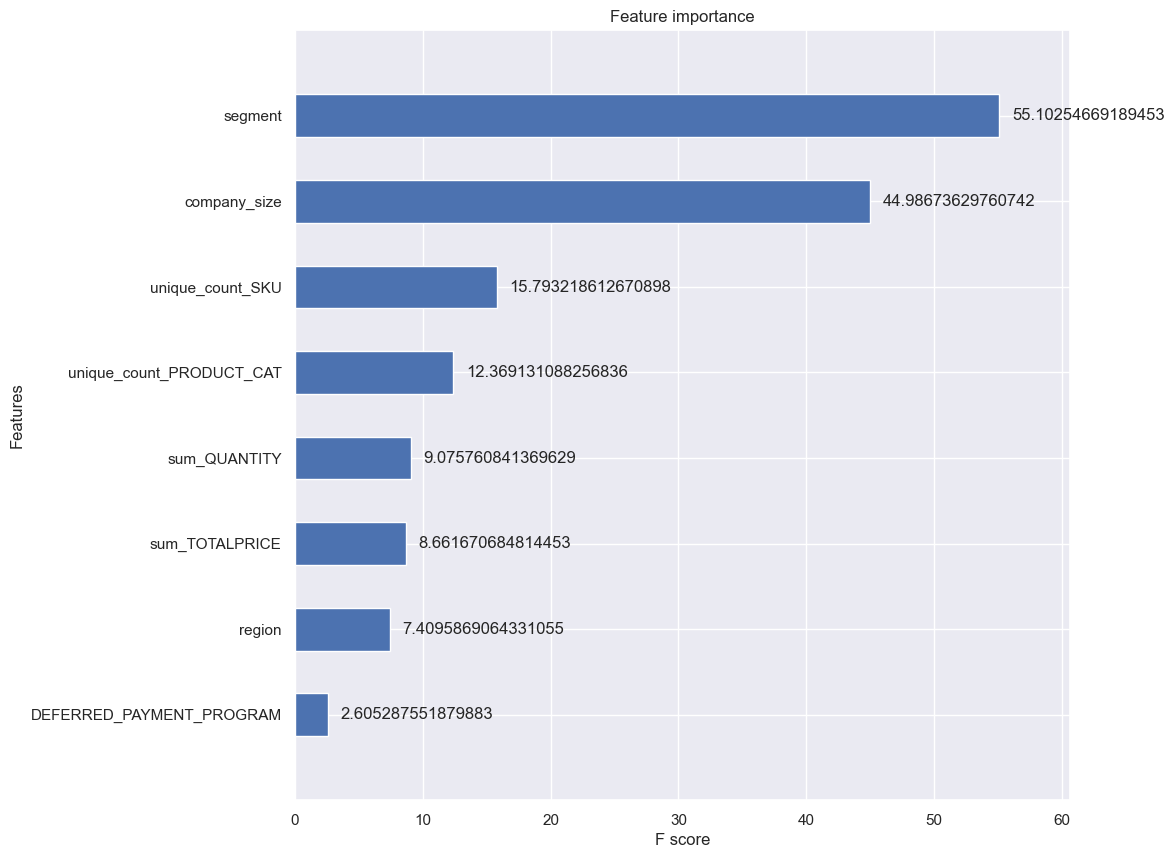

In [55]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgb_model, max_num_features=10, height=0.5, ax=ax,importance_type='gain')
plt.show()

# Preprocess Evalaution data

In [56]:
get_firing_rates(df_eval)

,Count,Unique,Most Common Value,Freq,Unique %,Fire Rate %,Null Rate %
CUSTOMER_ID,"54,172","31,954",17780814737591576583,16,58.99%,100.00%,0.00%
REGION,"53,370",3,Eastern U.S.,"33,815",0.01%,98.52%,1.48%
COMPANY_SIZE,"54,172",6,1 to 99,"26,721",0.01%,100.00%,0.00%
SEGMENT,"54,172",6,SMALL,"28,795",0.01%,100.00%,0.00%
INITIAL_BOOKED_QUARTER,"54,160",43,2017Q1,"18,870",0.08%,99.98%,0.02%
LIFETIME_BOOKINGS_BEFORE_PURCHASE,"35,253","17,801",389.72,173,32.86%,65.08%,34.92%
DEFERRED_PAYMENT_PROGRAM,"54,172",2,False,"46,993",0.00%,100.00%,0.00%
BOOKING_TYPE,"54,172",2,End Cust,"51,206",0.00%,100.00%,0.00%
BOOKED_FISCAL_QUARTER,"54,172",1,2017Q1,"54,172",0.00%,100.00%,0.00%
PRODUCT_CAT,"54,172",3,Y,"23,450",0.01%,100.00%,0.00%


In [57]:
df_eval=pd.read_csv('eval.gzip',compression='gzip')
df_eval1=df_eval.groupby(['CUSTOMER_ID']).sum()[['QUANTITY','TOTALPRICE']]
df_eval1.reset_index(inplace=True)
df_eval2=df_eval.groupby(['CUSTOMER_ID'])[['PRODUCT_CAT','SKU']].nunique()
df_eval2.reset_index(inplace=True)
#joined df_eval1 and df_eval2 to have aggregations on the line level in one dataframe
df_eval_line_level=pd.merge(df_eval1,df_eval2, on=['CUSTOMER_ID'], how='left')
#Rename columns
df_eval_line_level.columns=['CUSTOMER_ID','sum_QUANTITY','sum_TOTALPRICE',
                            'unique_count_PRODUCT_CAT','unique_count_SKU']
df_eval_account_level=df_eval[['CUSTOMER_ID', 'REGION', 'COMPANY_SIZE',
       'SEGMENT','DEFERRED_PAYMENT_PROGRAM']]
df_eval_account_level=df_eval_account_level.drop_duplicates()
df_eval=pd.merge(df_eval_account_level,df_eval_line_level,on=['CUSTOMER_ID'],how='inner')
df_eval.head()


,CUSTOMER_ID,REGION,COMPANY_SIZE,SEGMENT,DEFERRED_PAYMENT_PROGRAM,sum_QUANTITY,sum_TOTALPRICE,unique_count_PRODUCT_CAT,unique_count_SKU
0,429011742848591,NaN,1 to 99,SMALL,True,43.0,23201.28,1,1
1,1217626247396393,Western U.S.,4000+,ENTERPRISE,True,202.0,130521.45,3,6
2,2651716598080643,Eastern U.S.,1 to 99,SMALL,False,1.0,392.43,1,1
3,2889364098185504,Eastern U.S.,1 to 99,SMALL,False,1.0,2760.64,1,1
4,3171362136805414,Western U.S.,1000 to 1999,COMMERCIAL,False,17.0,10836.23,2,2


### Preprocess the categorical fields

In [58]:
df_eval.loc[df_eval.REGION=='Eastern U.S.','region']=1
df_eval.loc[df_eval.REGION=='Western U.S.','region']=2
df_eval.loc[df_eval.REGION=='Canada','region']=3
df_eval.loc[df_eval.REGION.isnull(),'region']=4
df_eval.loc[df_eval.COMPANY_SIZE=='1 to 99','company_size']=1
df_eval.loc[df_eval.COMPANY_SIZE=='100 to 999','company_size']=2
df_eval.loc[df_eval.COMPANY_SIZE=='4000+','company_size']=3
df_eval.loc[df_eval.COMPANY_SIZE=='1000 to 1999','company_size']=4
df_eval.loc[df_eval.COMPANY_SIZE=='2000 to 3999','company_size']=5
df_eval.loc[df_eval.COMPANY_SIZE=='Unknown','company_size']=6
df_eval.loc[df_eval.SEGMENT=='SMALL','segment']=1
df_eval.loc[df_eval.SEGMENT=='COMMERCIAL','segment']=2
df_eval.loc[df_eval.SEGMENT=='OTHER','segment']=3
df_eval.loc[df_eval.SEGMENT=='PUBLIC SECTOR','segment']=4
df_eval.loc[df_eval.SEGMENT=='ENTERPRISE','segment']=5
df_eval.loc[df_eval.SEGMENT=='SERVICE PROVIDER','segment']=6

In [59]:
# Inputs for XGboost model
X_eval=df_eval[['DEFERRED_PAYMENT_PROGRAM','sum_QUANTITY','sum_TOTALPRICE','unique_count_PRODUCT_CAT',
                'unique_count_SKU','region', 'company_size', 'segment']]
y_eval_pred=xgb_model.predict(X_eval)
# Find probability of predicted output
df_final=pd.DataFrame(xgb_model.predict_proba(X_eval), columns = ['prob_as_0','prob_as_1'])
df_eval['target']=y_eval_pred
df_eval['proba_target']=df_final['prob_as_1']

### Find top accounts with the highest likelihood

In [60]:
df_eval[['CUSTOMER_ID', 'target','proba_target']].sort_values(by='proba_target',ascending=False).head(100)

,CUSTOMER_ID,target,proba_target
22147,12874781544935440070,1,0.979289
13429,7793791296662824632,1,0.972939
4732,2713100654142212955,1,0.970515
10372,6008361907626835721,1,0.970228
21814,12672816883173402563,1,0.967861
...,...,...,...
19988,11624288140422265568,1,0.878201
26861,15590942632067427066,1,0.878089
15052,8725697378399321952,1,0.876702
29552,17111275003672968216,1,0.876697


In [61]:
df_eval[['CUSTOMER_ID', 'target','proba_target']].sort_values(by='proba_target',ascending=False).head(100).to_csv('100_most_likely_to_spend_accounts.csv',index=False)

In [62]:
eval_as_1=len([i for i in list(y_eval_pred) if i==1])
ratio=eval_as_1/len(list(xgb_model.predict(X_eval)))
print('Probably 13.35% of the accounts will spend in the next fiscal quarter')

Probably 13.35% of the accounts will spend in the next fiscal quarter
